In [1]:
import string
import pandas as pd
import numpy as np
import pickle

from scipy.sparse import vstack
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import WordNetLemmatizer
from nltk import FreqDist

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

### workflow
tokenize= nltk.stopwords, nltk.puctuation  
normalization= lower case, lemmatize  
vectorize= sklearn.Tfidf, /gensim.Doc2vec  
model= sklearn.MultinomialNB, /keras.LSTM

#### load data and preprocess

In [2]:
data = pd.read_csv('Amazon_review_NLP/data/kindel_subset.csv')
neg = data.loc[data.binary_sent == 'neg']
pos = data.loc[data.binary_sent == 'pos']

In [3]:
print(data.shape)
print(pos.shape)
print(neg.shape)

(107148, 2)
(50000, 2)
(57148, 2)


In [7]:
test = pd.concat([pos.iloc[:100,:],neg.iloc[-100:,:]])

In [8]:
sw = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [9]:
def preprocessing(line):
    # lower case and tokenize
    text = word_tokenize(str(line).lower())
    # lemmatize
    words = [lemmatizer.lemmatize(word, 'v') for word in text if word not in sw]        
    text = ' '.join(words)
    # puctuation 
    text = text.translate(str.maketrans("","", string.punctuation))
    return text

In [10]:
preprocessing("I can't beleive he wouldn't do that... He's really freaking me out.")

'ca nt beleive would nt  s really freak '

In [11]:
pos_data = [preprocessing(p) for p in pos['reviewText']]
neg_data = [preprocessing(n) for n in neg['reviewText']]

In [12]:
data = pos_data + neg_data
labels = np.concatenate((pos.binary_sent.values,neg.binary_sent.values))

#### Split data for testing

In [13]:
# 80/20 train/test split 
train_X, test_X, train_y, test_y = train_test_split(data, labels, test_size = 0.2, \
    stratify = labels, random_state = 42)

In [14]:
print(len(train_y))

85718


In [15]:
w = [word for text in train_X for word in word_tokenize(text)]
features = FreqDist(w)

In [16]:
len(features)

127102

#### tfidf + MultinomialNB

In [17]:
def tfidf_multinb(n):
    # tfidf vectorize
    top_n_words = [top_n[0] for top_n in list(features.most_common(n))]
    tf = TfidfVectorizer().fit(top_n_words) # or max_tf =0.5
    train_X_tf = tf.transform(train_X) # same demension required 
    test_X_tf = tf.transform(test_X)
    
    # MultinomialNB classifier (clf)
    clf = MultinomialNB(alpha=0.001)
    clf.fit(train_X_tf, train_y)
    
    # predict
    pred = clf.predict(test_X_tf)
    
    return accuracy_score(pred, test_y), clf

In [18]:
# to reduce computation intensity, let's start with n=1000 
n = 1000
tfidf_multinb(n) 
# 0.86 is not bad

(0.855996266915539,
 MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))

#### compare different number words used 

In [ ]:
top_n_accuracy = [tfidf_multinb(n)[0] for n in range(1000, 20000, 1000)]

No handles with labels found to put in legend.


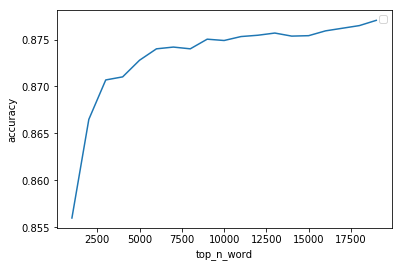

In [26]:
plt.plot([n for n in range(1000, 20000, 1000)], top_n_accuracy)
plt.xlabel(xlabel='top_n_word') 
plt.ylabel(ylabel='accuracy') 
plt.legend()

No handles with labels found to put in legend.


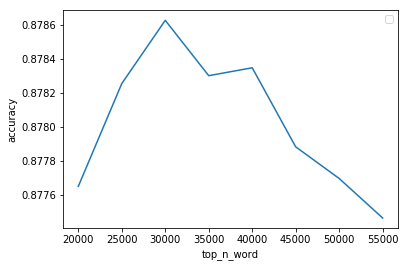

In [27]:
# because accuracy continues to grow, need to use more words
top_n_accuracy = [tfidf_multinb(n)[0] for n in range(20000, 60000, 5000)]
plt.plot([n for n in range(20000, 60000, 5000)], top_n_accuracy)
plt.xlabel(xlabel='top_n_word') 
plt.ylabel(ylabel='accuracy') 
plt.legend()

In [31]:
# 30000 seems to be the optimized number 
n = 30000
accu, final_clf = tfidf_multinb(n) 

In [34]:
accu

0.8786280914605693

#### Save model to pkl

In [33]:
pickle.dump(final_clf, open('tfidf_multinb.pkl', 'wb'))

#### TODO: Doc2vec + keras.LSTM